In [5]:
import numpy as np
import matplotlib.pyplot as plt
import mod_models as mm
import mod_visualization as mv
import mod_stimulation as ms
from mod_models import logger
import inputools.Trajectory as it
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

2023-11-17 00:41:34 | logger set up
2023-11-17 00:41:34 | cache path = /Users/daniekru/Research/lab/cache/
2023-11-17 00:41:34 | OS: mac


@toolpack


In [2]:
from IPython.display import clear_output
def clf():
    clear_output(wait=True)

# 1D
---

**Settings**

In [15]:
N = 10
Nj = 20
T = 20*1000

## Input

In [16]:
# input spikes
Sj = np.random.binomial(1, 10/1000, size=(T, Nj, 1))

bin_size = 1500

i = 0
j = 0
for t0 in range(0, T, bin_size+100):
    if i == N:
        break
    Sj[t0: t0 + bin_size, j] = np.random.binomial(1, 300/1000, size=(bin_size, 1))
    i += 1
    j += 1

In [17]:
# input spikes
Sj = np.random.normal(0, 0.1, (T, Nj, 1)).clip(0, 1)

bin_size = 500

i = 0
j = 0
for t0 in range(0, T, bin_size+100):
    if i == N:
        break
    Sj[t0: t0 + bin_size, j] = np.random.normal(0, 1., size=(bin_size, 1)).clip(0, 1)
    i += 1
    j += 1

## Model 

In [165]:
net = mm.Network(N=N, Nj=Nj, learnable=True, lr=3e-2, 
                  wr_const=3.75,
                  wff_const=5.5,
                  wff_max=4.,
                  wff_min=0.1,
                  wff_beta=0.02,
                  wff_tau=50,
                  wr_tau=75,
                  tau_u=55,
                  syn_ff_min=0.04,
                 )

2023-11-10 19:41:34 | Network(N=16, Nj=25)


#### Connectivity

2023-11-10 17:18:57 | Recurrent weights set (10, 10)


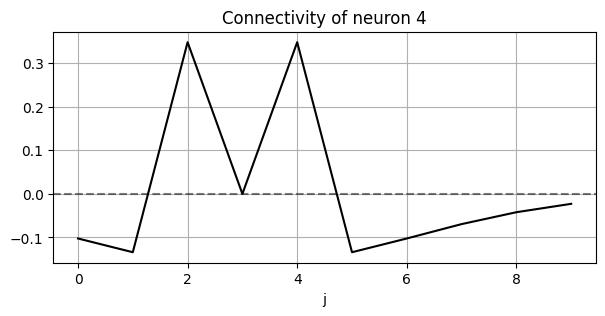

In [19]:
w = mod.mexican_hat_1D(N=N, A=1., B=.045, sigma_exc=.5, sigma_inh=3)

net.set_wrec(w)
#mv.plot_weight_matrix(net.Wrec)

plt.figure(figsize=(7, 3))
plt.axhline(0, color="black", alpha=0.5, linestyle='--')
plt.plot(range(N), net.Wrec[3], '-k')
plt.title("Connectivity of neuron 4")
plt.xlabel("j")
plt.grid()
plt.show()

In [20]:
net.Wrec.max()

0.347876651759281

## Simulation

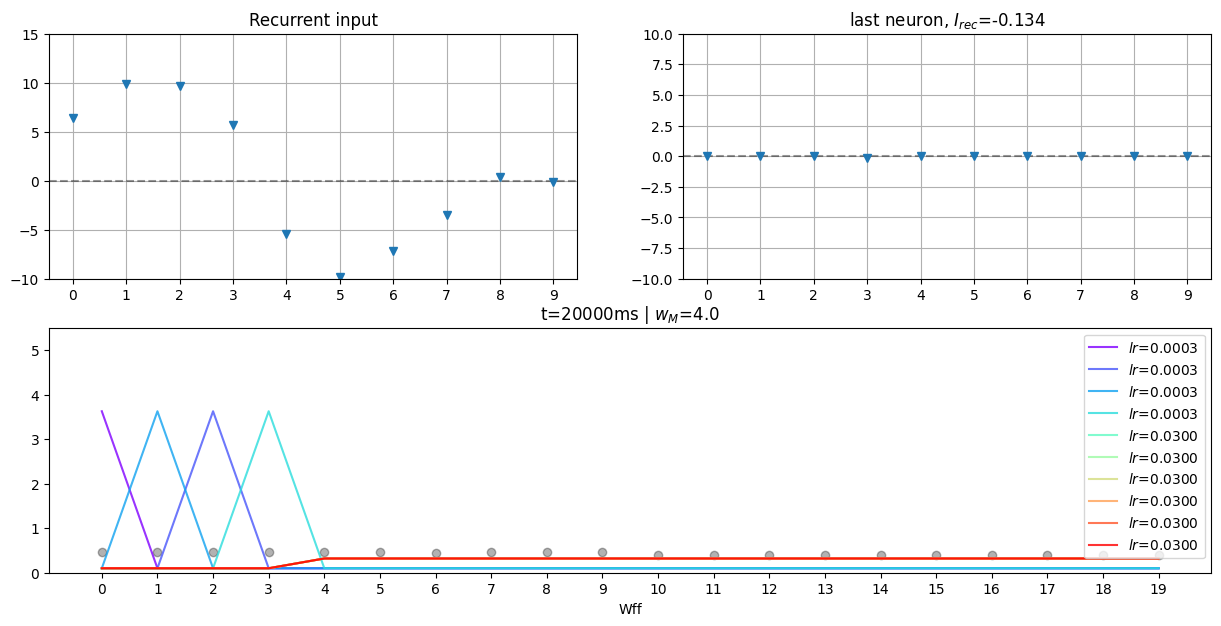

.


In [21]:
net.reset()

tp = 200

sp = np.zeros(Nj)
for t in range(T):

    net.step(Sj=Sj[t])
    sp += Sj[t, :, 0]

    #plt.clf()
    if t%tp == 0:
        clf()
        fig = plt.figure(figsize=(15, 7))

        plt.subplot(221)
        plt.axhline(0, color="black", linestyle="--", alpha=0.4)
        plt.plot(range(N), net.record[:, 1], 'v')
        plt.ylim((-10, 15))
        plt.grid()
        plt.xticks(range(N))
        plt.title("Recurrent input")

        plt.subplot(222)
        plt.axhline(0, color="black", linestyle="--", alpha=0.4)
        plt.plot(range(N), net.record[:, 2], 'v')
        plt.ylim((-10, 10))
        plt.grid()
        plt.xticks(range(N))
        plt.title("last neuron, $I_{rec}$="+f"{net.record[:, 2].sum():.3f}")

        plt.subplot(212)
        plt.plot(range(Nj), sp / (t+1) * 10, 'ok', alpha=0.3)

        for i in range(N):
            plt.plot(range(Nj), net.Wff[i], alpha=0.8, color=net.colors[i],
                     label=f"$lr$={net._lr[i, 0]:.4f}")
        plt.xlabel("Wff")
        plt.title(f"t={t+tp}ms | $w_M$={net.wff_max}")
        plt.ylim((0, 5.5))
        plt.xticks((range(Nj)))
        plt.legend(loc="upper right")
        plt.pause(0.01)

print(".")

In [314]:
net.record[:, 1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# 2D - spatial inputs
---
All neurons in the input layer are spatially tuned

## Inputs

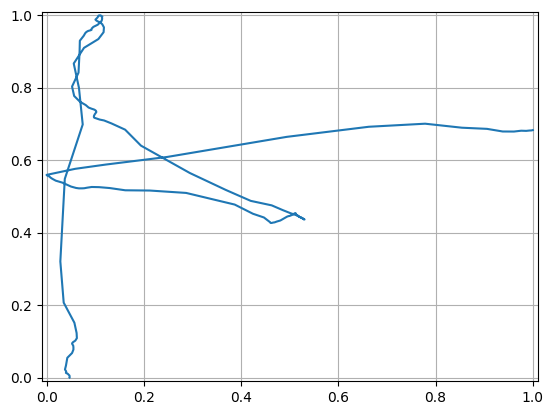

(1000, 2)


In [358]:
# Create an animal
animal = ms.AnimalTrajectory(dt=1, 
                             prob_turn=0.1, 
                             prob_speed=0.01,
                             prob_rest=0.01, 
                             day_cycle=True)

# Create a trajectory
trajectory = animal.make_trajectory(duration=1000, whole=False, dx=0.005)

# Plot the trajectory
plt.plot(trajectory[:, 0], trajectory[:, 1])
plt.ylim((-0.01, 1.01))
plt.xlim((-0.01, 1.01))
plt.grid()
plt.show()

print(trajectory.shape)

#### Settings

In [351]:
N = 9
Nj = 9
T = 10 # 1 step/s
bounds = (0, 1, 0, 1)

**Input layer**

In [385]:
layer = ms.InputLayer(N=Nj, kind='place', sigma=0.02, max_rate=10, min_rate=0)
logger.info(layer.__repr__())

Sj = layer.parse_trajectory(trajectory, timestep=1, mode='rate') 
logger.info(Sj.shape)

2023-11-14 20:05:00 | InputLayer(N=9, kind=place, sigma=0.02)
2023-11-14 20:05:00 | (10000, 9)


In [379]:
layer = ms.InputLayer(N=Nj, kind='place', sigma=0.04, max_rate=100, min_rate=0)
logger.info(layer.__repr__())

dataset, trajectories = it.make_dataset(n_samples=3, animal=animal, layer=layer, duration=10_000, dx=0.01, mode='rate', return_trajectory=True)
trajectory = trajectories[0]
Sj = dataset[0]

logger.info(trajectory.shape)

2023-11-14 18:26:11 | InputLayer(N=9, kind=place, sigma=0.04)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.34it/s]
2023-11-14 18:26:12 | (10000, 2)


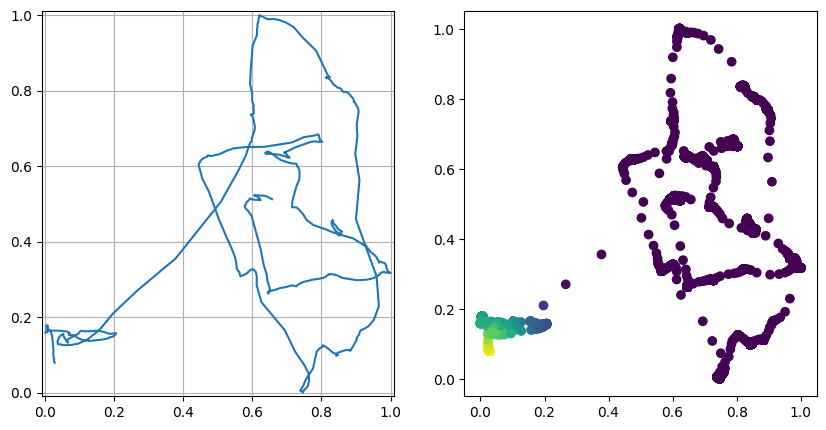

In [380]:
# Plot the trajectory
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(trajectory[:, 0], trajectory[:, 1])
plt.ylim((-0.01, 1.01))
plt.xlim((-0.01, 1.01))
plt.grid()

plt.subplot(122)
plt.scatter(trajectory[:, 0], trajectory[:, 1], c=Sj[:, 0])

plt.show()

## Model

2023-11-14 20:05:04 | RateNetwork(N=9, Nj=9) [YkmmT]


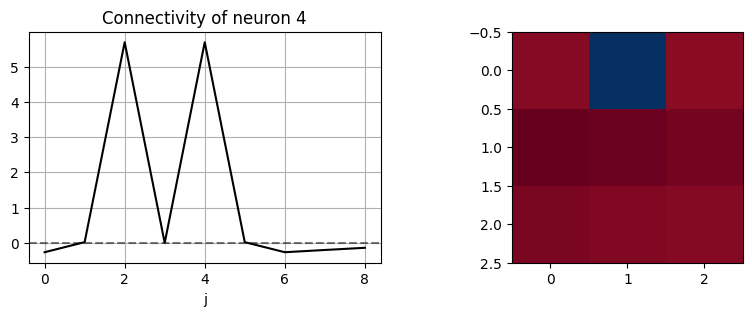

In [386]:
net = mm.NetworkSimple(
    N=N, Nj=Nj, lr=3e-2, 
                  wr_const=4.55,
                  wff_const=5.,
                  wff_max=4.5,
                  wff_min=0.01,
                  wff_beta=0.1,
                  wff_tau=50,
                  wr_tau=55,
                  tau_u=85,
                  syn_ff_min=0.045,
                  dim=1,
                  A=3.45,
                  B=0.085,
                  sigma_exc=.725,
                  sigma_inh=3.5
                 )
net = mm.RateNetwork(
    N=N, Nj=Nj, lr=3e-2, 
                  wr_const=4.55,
                  wff_const=5.,
                  wff_max=4.5,
                  wff_min=0.01,
                  wff_beta=0.1,
                  wff_tau=50,
                  wr_tau=55,
                  tau_u=85,
                  syn_ff_min=0.045,
                  dim=1,
                  A=3.45,
                  B=0.085,
                  sigma_exc=.725,
                  sigma_inh=3.5
                 )
logger.info(net)

plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.axhline(0, color="black", alpha=0.5, linestyle='--')
plt.plot(range(N), net.Wrec[3], '-k')
plt.title("Connectivity of neuron 4")
plt.xlabel("j")
plt.grid()

plt.subplot(122)
plt.imshow(net.Wrec[0].reshape(net.n, net.n), cmap="RdBu")

plt.show()

## Simulation on trajectory

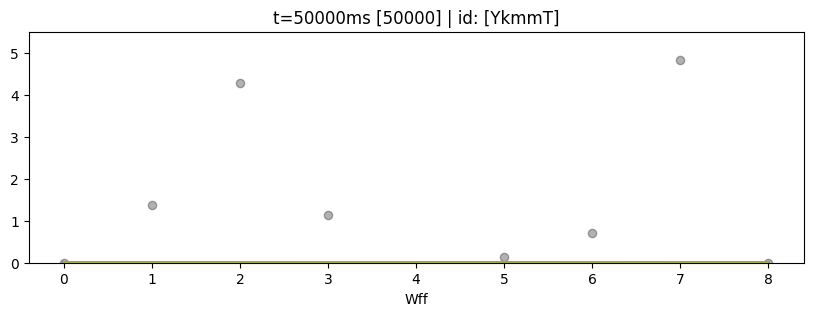

.


In [387]:
# Settings
dataset = it.make_dataset(n_samples=1, animal=animal, layer=layer, duration=50000, timestep=1, dx=0.1, mode='rate')
net.reset()

tp = 1000

sp = np.zeros(Nj)
Sj = dataset[0]
for t in range(len(Sj)):

    net.step(Sj=Sj[t].reshape(-1, 1))
    sp += Sj[t, :]

    #plt.clf()
    if t%tp == 0:
        clf()
        fig = plt.figure(figsize=(10, 3))

        plt.subplot(111)
        plt.plot(range(Nj), sp / (t+1) * 10, 'ok', alpha=0.3)

        for i in range(N):
            plt.plot(range(Nj), net.Wff[i], alpha=0.8,
                     label=f"$lr$={net._lr[i, 0]:.4f}")
        plt.xlabel("Wff")
        plt.title(f"t={t+tp}ms [{len(Sj)}] | id: [{net.id}]")
        plt.ylim((0, 5.5))
        plt.xticks((range(Nj)))
        plt.pause(0.01)

print(".")

## Analysis
---

### Input Layer

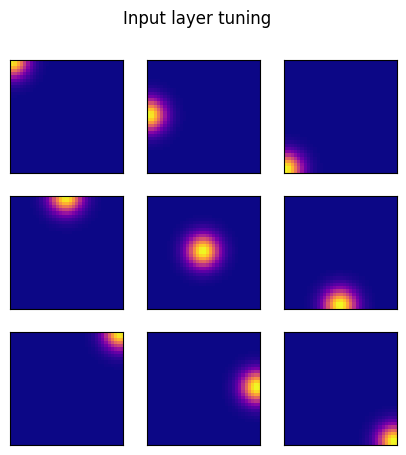

In [388]:
#layer = ms.InputLayer(N=Nj, kind='place', bounds=(0.05, 0.95, 0.05, 0.95),
#                      sigma=0.04, max_rate=300, min_rate=10)

rate = ms.get_network_tuning(layer=layer, mode='rate', 
                                dx=0.03, 
                                timestep=1)

fig, rows = plt.subplots(layer.n, layer.n, figsize=(5, 5))

fig.suptitle("Input layer tuning")
i = 0
for cols in rows:
    for ax in cols:
        ax.imshow(rate[:, i].reshape(int(np.sqrt(len(rate))), int(np.sqrt(len(rate)))), cmap='plasma')
        i += 1
        ax.set_xticks(())
        ax.set_yticks(())
        
plt.show()

### PC network

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 441/441 [00:00<00:00, 38639.82it/s]


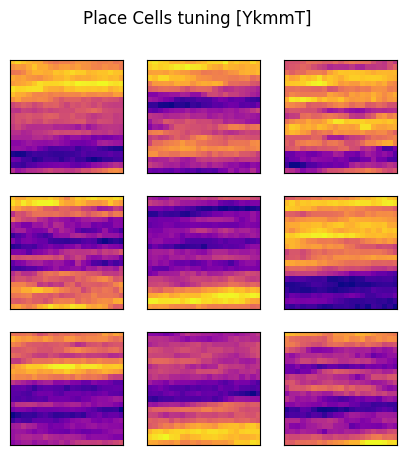

In [390]:
net.set_plastic(plastic=False)
rate_pc = it.get_network_tuning(model=net, layer=layer, mode='rate', 
                                          dx=0.05, 
                                          timestep=1,
                                reset=False
                               )

nrows = net.n
ncols = net.n
fig, rows = plt.subplots(nrows, ncols, figsize=(5, 5))
fig.suptitle(f"Place Cells tuning [{net.id}]")
i = 0
for cols in rows:
    for ax in cols:
        ax.imshow(rate_pc[:, i].reshape(int(np.sqrt(len(rate_pc))), 
                                        int(np.sqrt(len(rate_pc)))),
                                        cmap='plasma')
        i += 1
        ax.set_xticks(())
        ax.set_yticks(())
        
plt.show()

**FeedFoward Weights**

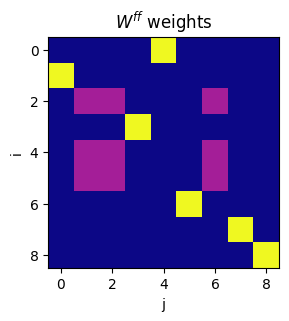

In [60]:
plt.figure(figsize=(3, 3))
plt.imshow(net.Wff, cmap="plasma")
plt.title("$W^{ff}$ weights")
plt.xlabel('j')
plt.ylabel('i')
plt.show()

In [66]:
net.Wff.max(axis=1)

array([4.5       , 4.5       , 1.62687655, 4.5       , 1.62780706,
       1.62724435, 4.5       , 4.5       , 4.5       ])

**Dataset**

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 245.31it/s]


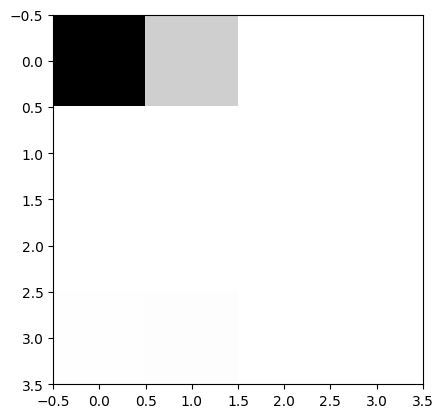

In [260]:
layer = it.InputLayer(N=16, sp=1., kind='place', bounds=(0.05, 0.95, 0.05, 0.95),
                      sigma=0.001, max_rate=300, min_rate=10)

dataset = it.make_dataset(n_samples=3, animal=animal, layer=layer, duration=100, dx=0.1, mode='rate')
plt.imshow(np.around(dataset[2], 5).sum(axis=0).reshape(4, 4), cmap="Grays")

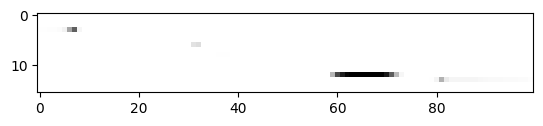

In [242]:
plt.imshow(np.around(dataset[2], 5).T, cmap="Grays")

# 2D - mixed inputs
---
Only a fraction of inputs neurons are spatially tuned

## Input

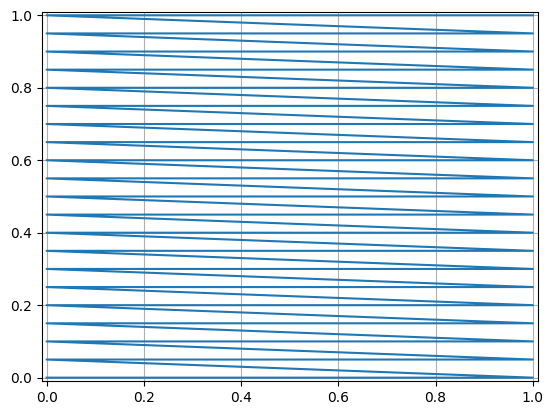

(441, 2)


In [131]:
# Create an animal
animal = ms.AnimalTrajectory(dt=1, 
                             prob_turn=0.01, 
                             prob_speed=0.1,
                             prob_rest=0.01, 
                             day_cycle=True)

# Create a trajectory
trajectory = animal.make_trajectory(duration=100, whole=True, dx=0.05)

# Plot the trajectory
plt.plot(trajectory[:, 0], trajectory[:, 1])
plt.ylim((-0.01, 1.01))
plt.xlim((-0.01, 1.01))
plt.grid()
plt.show()

print(trajectory.shape)

#### Settings

In [95]:
N = 9
Nj = 4**2
T = 10 # 1 step/s
bounds = (0, 1, 0, 1)

#### Layer

In [264]:
layer = it.InputLayer(N=Nj, sp=1., kind='place', bounds=(0.05, 0.95, 0.05, 0.95),
                      sigma=0.01, max_rate=300, min_rate=10)

logger.info(layer.__repr__())

Sj = layer.parse_trajectory(trajectory, timestep=100, mode='spike') 
logger.info(Sj.shape)

2023-11-14 18:13:45 | InputLayer(N=16, Nsp=16, kind=place, sigma=0.01)
2023-11-14 18:13:45 | (44100, 16)


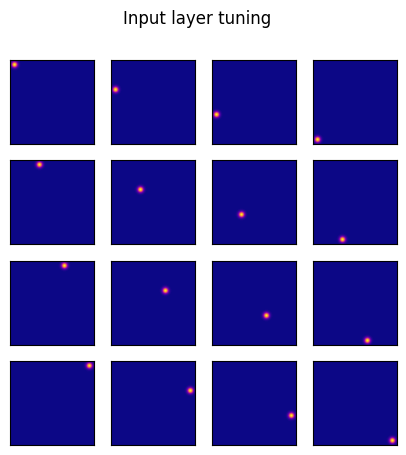

In [263]:
rate = ms.get_network_tuning(layer=layer, mode='rate', 
                                dx=0.01, 
                                timestep=1)

fig, rows = plt.subplots(layer.n, layer.n, figsize=(5, 5))

fig.suptitle("Input layer tuning")
i = 0
for cols in rows:
    for ax in cols:
        ax.imshow(rate[:, i].reshape(int(np.sqrt(len(rate))), int(np.sqrt(len(rate)))), cmap='plasma')
        i += 1
        ax.set_xticks(())
        ax.set_yticks(())
        
plt.show()

In [134]:
np.around(layer.step(np.array([0.5, 0.5])), 3)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [138]:
layer.centers

array([[0.05    , 0.05    ],
       [0.10625 , 0.05    ],
       [0.1625  , 0.05    ],
       [0.21875 , 0.05    ],
       [0.078125, 0.10625 ],
       [0.134375, 0.10625 ],
       [0.190625, 0.10625 ],
       [0.246875, 0.10625 ],
       [0.05    , 0.1625  ],
       [0.10625 , 0.1625  ],
       [0.1625  , 0.1625  ],
       [0.21875 , 0.1625  ],
       [0.078125, 0.21875 ],
       [0.134375, 0.21875 ],
       [0.190625, 0.21875 ],
       [0.246875, 0.21875 ]])

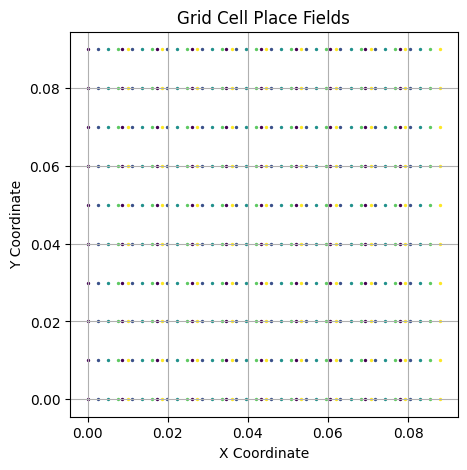

In [219]:
class GridCellNetwork:
    def __init__(self, bounds, num_cells, grid_spacing, dx):
        self.bounds = bounds
        self.dx = dx
        self.num_cells = num_cells
        self.grid_spacing = grid_spacing * 20

    def _generate_grid_centers(self):
        x_min, x_max, y_min, y_max = self.bounds
        spacing_x = self.grid_spacing
        spacing_y = np.sqrt(3) * spacing_x / 2

        centers = []
        startx = np.linspace(x_min, x_min+0.01, self.num_cells)
        starty = np.linspace(y_min, y_min+0.0, self.num_cells)

        for k in range(self.num_cells):
            #print(k)
            # Randomly choose a starting point for each cell's grid
            start_x = startx[k]#np.random.uniform(x_min, x_max)
            start_y = starty[k]#np.random.uniform(y_min, y_max)
            cell_centers = []

            for i in np.arange(y_min, y_max, self.dx):  # Adjust the range for the desired grid size
                for j in np.arange(x_min, x_max, self.dx):
                    #print(i,j)
                    y = start_y + i * spacing_x - (i % 2) * spacing_x / 2
                    x = start_x + j * spacing_y - (j % 2) * spacing_y / 2
                    if x_min <= x <= x_max and y_min <= y <= y_max:
                        cell_centers.append((x, y))

            centers.append(cell_centers)
        return np.array(centers)

    def plot_grid_cells(self):
        cell_centers = self._generate_grid_centers()
        colors = plt.cm.viridis(np.linspace(0, 1, self.num_cells))

        plt.figure(figsize=(5, 5))
        for idx, centers in enumerate(cell_centers):
            x_vals, y_vals = zip(*centers)
            plt.scatter(x_vals, y_vals, color=colors[idx], label=f'Cell {idx+1}', s=2)

        plt.title("Grid Cell Place Fields")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.grid(True)
        #plt.xlim(self.bounds[0], self.bounds[1])
        #plt.ylim(self.bounds[2], self.bounds[3])
        #plt.legend()
        plt.show()

# Parameters for the network
bounds = (0, 1, 0, 1)
num_cells = 5
grid_spacing = 0.01  # Adjust as needed

network = GridCellNetwork(bounds, num_cells, grid_spacing, dx=0.1)
network.plot_grid_cells()

In [141]:
grid_centers

array([[0.        , 0.        ],
       [1.        , 0.        ],
       [2.        , 0.        ],
       [3.        , 0.        ],
       [4.        , 0.        ],
       [5.        , 0.        ],
       [6.        , 0.        ],
       [7.        , 0.        ],
       [8.        , 0.        ],
       [9.        , 0.        ],
       [0.5       , 0.8660254 ],
       [1.5       , 0.8660254 ],
       [2.5       , 0.8660254 ],
       [3.5       , 0.8660254 ],
       [4.5       , 0.8660254 ],
       [5.5       , 0.8660254 ],
       [6.5       , 0.8660254 ],
       [7.5       , 0.8660254 ],
       [8.5       , 0.8660254 ],
       [9.5       , 0.8660254 ],
       [0.        , 1.73205081],
       [1.        , 1.73205081],
       [2.        , 1.73205081],
       [3.        , 1.73205081],
       [4.        , 1.73205081],
       [5.        , 1.73205081],
       [6.        , 1.73205081],
       [7.        , 1.73205081],
       [8.        , 1.73205081],
       [9.        , 1.73205081],
       [0.

# Old
---

In [ ]:
# Parameters
#grid_size = int(np.sqrt(Nj))  # Size of the grid (N x N)


# Generate the forward-only walk trajectory and activationsiiiiiii
forward_trajectory, forward_activations = ms.generate_walk_trajectory(steps=10, layer=layer, verbose=True)

# Visualize the forward-only trajectory and neuron activations
ms.visualize_trajectory_and_activations(forward_trajectory, forward_activations, bounds)

logger.info(f"Trajectory: \n{forward_trajectory.T}")
logger.info(f"Activations shape: {len(forward_activations)}, {forward_activations[0].shape}")

# make spikes
Sj = ms.make_spiking_trajectory(Nj=Nj, activations=forward_activations, stm_duration=1000, 
                                pause_time=100, base_rate=10, stm_rate=300, binary=True)

# Connectivity
---

**1D**

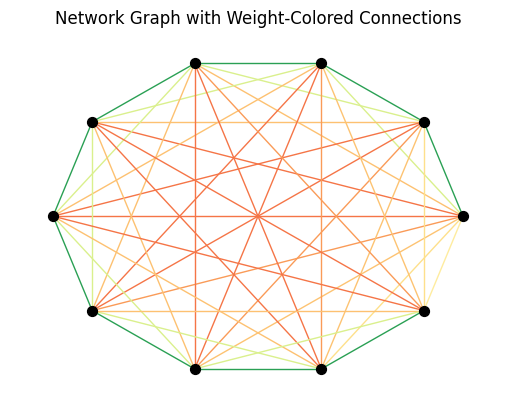

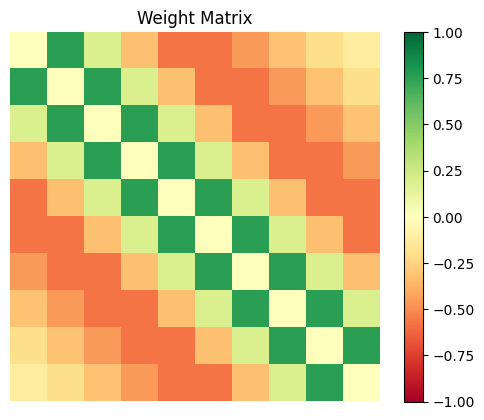

In [7]:
# Generate the Mexican hat connectivity pattern for the smaller network
w = mm.mexican_hat_1D(N=10, A=2.5, B=1.5, sigma_exc=2, sigma_inh=4.)

# plot
mv.plot_graph_colored_1D(w)
mv.plot_weight_matrix(w)

**2D**

In [8]:
# Define a smaller network for clearer visualization
dims = (8, 8)
A = 2.  # Excitatory strength
B = 1.  # Inhibitory strength
sigma_exc = 2.0  # Excitatory spread
sigma_inh = 4.0  # Inhibitory spread

# Generate the Mexican hat connectivity pattern for the smaller network
w = mm.mexican_hat_2D(dims, A, B, sigma_exc, sigma_inh)

# plot
mv.plot_graph_colored_2D(w, dims, threshold=0.37)

TypeError: only length-1 arrays can be converted to Python scalars

In [9]:
soft = lambda x, b: np.exp(b*x) / np.exp(b*x).sum(axis=0)

In [13]:
w = np.random.randint(0, 10, (5)) / 10
sw = soft(w, b=10.05)
print(w, '\n\nsoftmax:\n', np.around(sw, 3), '\n\nmultiplers:\n', sw / sw.max(axis=0))

[0.1 0.4 0.  0.2 0.4] 

softmax:
 [0.022 0.454 0.008 0.061 0.454] 

multiplers:
 [0.04904584 1.         0.01795296 0.13398867 1.        ]


In [278]:
sw / sw.max(axis=0) * w

array([[0.        , 0.        , 2.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 2.        ],
       [0.2657752 , 0.        , 1.32947658, 0.        , 0.        ]])

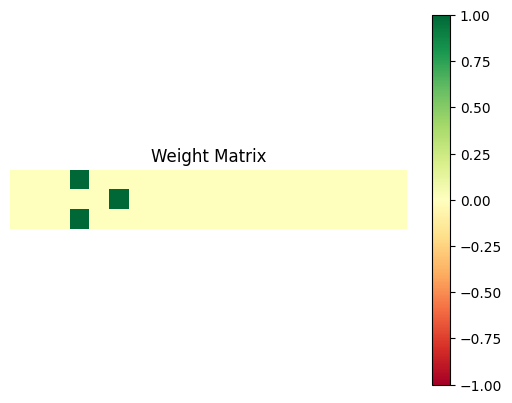

In [233]:
mv.plot_weight_matrix(net.Wff)

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]


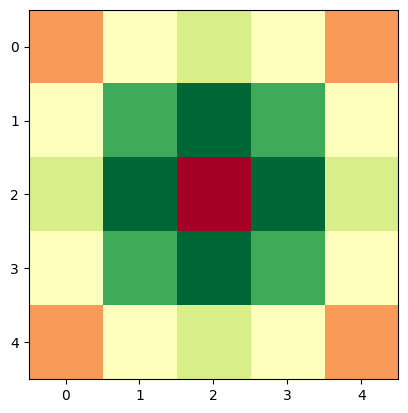

In [10]:
N = 25
ns = int(np.sqrt(N))
A = 2
B = 0.5
sigma_exc = 2
sigma_inh = 4

w = np.zeros((N, N))
ids = [*mod.iterprod(range(ns), range(ns))]
print(ids)

for i in range(N):
    #print()
    for j in range(N):
        if i == j:
            #print("         0          ", end="")
            #print(end="  .     ")
            continue
        #print(f"({ids[i][0]}-{ids[j][0]})^2 + ({ids[i][1]}-{ids[j][1]})^2   ", end="")
        dij = np.sqrt((ids[i][0]-ids[j][0])**2 + (ids[i][1]-ids[j][1])**2)
        wij = A * np.exp(-(dij**2)/(2*sigma_exc**2)) - B * np.exp(-(dij**2)/(2*sigma_inh**2))
        w[i,j] = wij
        #print(f"{wij:.2f}", end="    ")

#plt.imshow(w, cmap='Blues')
#plt.show()
plt.imshow(w[12].reshape(ns, ns), cmap="RdYlGn");
#print('\n\n', w)